## Modifiez la variable analyzed_sales pour changer le scope de la prediction
valeurs possibles : 'Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('vgsales.csv')
analyzed_sales = 'Global_Sales'

In [151]:
df = df[df.Year < 2015]
df = df.dropna()
df[analyzed_sales] = df[analyzed_sales].apply(lambda x: x*1000)

def create_price(data) :
    price = {'Wii': 50, 'NES' : 40, 'GB' : 30, 'DS' : 35, 'X360' : 60, 'PS3' : 60, 'PS2' : 50, 'SNES' : 60,
             'GBA' : 35, '3DS' : 40, 'PS4' : 60, 'N64' : 50, 'PS' : 50, 'XB' : 50, 'PC' : 50, '2600' : 40,
             'PSP' : 50, 'XOne' : 60, 'GC' : 50, 'WiiU' : 60, 'GEN' : 50, 'DC' : 50, 'PSV' : 50, 'SAT' : 50,
             'SCD' : 80, 'WS' : 70, 'NG' : 200, 'TG16' : 50,
       '3DO' : 50, 'GG' : 50, 'PCFX' : 50}
    prices = []
    for elem in range(len(data)) :
        #print(price[data['Platform'][elem]])
        x = price[data.iloc[elem]['Platform']]
        calc = round(np.random.normal(x, x / 10), 2)
        prices.append(calc);
    data["Price"] = prices
    return data

def create_notation(data) :
    notations_list = []
    for elem in range(len(data)) :
        notation = round(np.random.normal(10, 1) + ((data["Rank"].max() - data.iloc[elem]["Rank"]) / data["Rank"].max()) * 5, 2)
        notations_list.append(notation)
    data["Notation"] = notations_list
    return data

df = create_price(df)
#df = create_notation(df)

for platform in df.Platform.unique():
    if df[df.Platform == platform].shape[0] <= 20:
        df = df[df.Platform != platform]

for publisher in df.Publisher.unique():
    if df[df.Publisher == publisher].shape[0] <= 20:
        df = df[df.Publisher != publisher]

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13263 entries, 0 to 16595
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          13263 non-null  int64  
 1   Name          13263 non-null  object 
 2   Platform      13263 non-null  object 
 3   Year          13263 non-null  float64
 4   Genre         13263 non-null  object 
 5   Publisher     13263 non-null  object 
 6   NA_Sales      13263 non-null  float64
 7   EU_Sales      13263 non-null  float64
 8   JP_Sales      13263 non-null  float64
 9   Other_Sales   13263 non-null  float64
 10  Global_Sales  13263 non-null  float64
 11  Price         13263 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.3+ MB


In [154]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.3, random_state=12)
y_train, y_test = X_train[analyzed_sales], X_test[analyzed_sales]
X_train = X_train.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
X_test = X_test.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)

In [155]:
from sklearn.base import BaseEstimator, TransformerMixin

class ClearAttributes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.drop(['Rank', 'Name', 'Publisher'], axis=1)
        return X

In [156]:
clear_attributes = ClearAttributes()

In [157]:
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ['Platform', 'Genre']
jv_cat = X_train[cat_attribs]
cat_encoder = OneHotEncoder()
jv_cat_1hot = cat_encoder.fit_transform(jv_cat)

In [158]:
cat_encoder.categories_

[array(['2600', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'N64', 'NES',
        'PC', 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV', 'SAT', 'SNES',
        'Wii', 'WiiU', 'X360', 'XB', 'XOne'], dtype=object),
 array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
        'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
        'Strategy'], dtype=object)]

In [160]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

clean_attributes = ['Rank', 'Year', 'Name', 'Publisher']
num_attributes = ['Year', 'Price']

pipeline = ColumnTransformer([
    ('clean', tmp, clean_attributes),
    ('std_scaler', StandardScaler(), num_attributes),
    ('cat', OneHotEncoder(), cat_attribs)
])

jv_prepared = pipeline.fit_transform(X_train)

In [161]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(jv_prepared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [162]:
from sklearn.metrics import mean_squared_error

jv_predictions = lin_reg.predict(jv_prepared)
lin_mse = mean_squared_error(y_train, jv_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1814.775134609252

In [177]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(jv_prepared, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [180]:
jv_predictions = dtr.predict(jv_prepared)
dtr_mse = mean_squared_error(y_train, jv_predictions)
dtr_rmse = np.sqrt(dtr_mse)
dtr_rmse

79.17508099837136

In [183]:
X_test_prepared = pipeline.transform(X_test)
final_predictions = lin_reg.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

1234.0379273038002

In [186]:
X_test_prepared = pipeline.transform(X_test)
final_predictions = lin_reg.predict(X_test_prepared)
np.std(final_predictions)

379.57542285196115

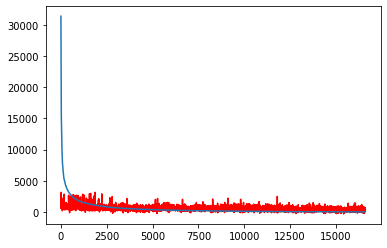

In [187]:
import matplotlib.pyplot as plt

X_test = X_test.sort_index()
y_test = y_test.sort_index()
plt.plot(X_test.index, final_predictions, 'r')
plt.plot(X_test.index, y_test)
plt.show()

## Entrez ici vos donnees a tester

In [207]:
#modifiez la liste ci-dessous avec vos donnees
data = [[42, 'Example', '3DS', 2012, 'Action', 'Nintendo', 42]]
df_professor = pd.DataFrame(data, columns=['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'Price'])
df_prepared = pipeline.transform(df_professor)
prediction_professor = lin_reg.predict(df_prepared)
prediction_professor

array([738.68119499])